**Executed:** Mon Oct 10 11:42:33 2016

**Duration:** 50 seconds.

# Leakage coefficient fit

> *This notebook estracts the leakage coefficient from multi-spot smFRET measurements of 4 dsDNA samples.*

## Import software

In [1]:
from fretbursts import *
sns = init_notebook()

 - Optimized (cython) burst search loaded.
 - Optimized (cython) photon counting loaded.


--------------------------------------------------------------
 You are running FRETBursts (version 0.5.9).

 If you use this software please cite the following paper:

   FRETBursts: An Open Source Toolkit for Analysis of Freely-Diffusing Single-Molecule FRET
   Ingargiola et al. (2016). http://dx.doi.org/10.1371/journal.pone.0160716 

--------------------------------------------------------------


In [2]:
import seaborn

In [3]:
import os
import pandas as pd
from IPython.display import display
from IPython.display import display, Math

## Data files

In [4]:
data_dir = './data/multispot/'

In [5]:
data_dir = os.path.abspath(data_dir) + '/'
assert os.path.exists(data_dir), "Path '%s' does not exist." % data_dir

In [6]:
from glob import glob
file_list = sorted(glob(data_dir + '*.hdf5'))

In [7]:
labels = ['7d', '12d', '17d', '22d', '27d', 'DO']
files_dict = {lab: fname for lab, fname in zip(sorted(labels), file_list)}
files_dict

{'12d': '/Users/anto/Google Drive/notebooks/multispot_paper/data/multispot/12d_New_30p_320mW_steer_3.hdf5',
 '17d': '/Users/anto/Google Drive/notebooks/multispot_paper/data/multispot/17d_100p_320mW_steer_1.hdf5',
 '22d': '/Users/anto/Google Drive/notebooks/multispot_paper/data/multispot/22d_30p_320mW_steer_1.hdf5',
 '27d': '/Users/anto/Google Drive/notebooks/multispot_paper/data/multispot/27d_50p_320mW_steer_1.hdf5',
 '7d': '/Users/anto/Google Drive/notebooks/multispot_paper/data/multispot/7d_New_150p_320mW_steer_3.hdf5',
 'DO': '/Users/anto/Google Drive/notebooks/multispot_paper/data/multispot/DO12_No2_50p_320mW_steer_1.hdf5'}

## Plot style

In [8]:
PLOT_DIR = './figure/'

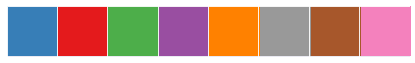

In [9]:
import matplotlib as mpl
from cycler import cycler

bmap = sns.color_palette("Set1", 9)
colors = np.array(bmap)[(1,0,2,3,4,8,6,7), :]
colors_labels = ['blue', 'red', 'green', 'violet', 'orange', 'gray', 'brown', 'pink', ]
for c, cl in zip(colors, colors_labels):
    locals()[cl] = tuple(c) # assign variables with color names

mpl.rcParams['axes.prop_cycle'] = cycler('color', colors)
sns.palplot(colors)

## Analysis Parameters

In [10]:
## Background fit
bg_kwargs_auto = dict(fun=bg.exp_fit,
                 time_s = 30,
                 tail_min_us = 'auto',
                 F_bg=1.7,
                 )

## Burst search
F = 6
ph_sel = Ph_sel(Dex='Dem') 
#ph_sel = Ph_sel('all') 
size_min = 80

## D-only peak fit with KDE
bandwidth = 0.03
binwidth = 0.025
E_range_do = (-0.05, 0.1)
weights = 'size'

In [11]:
df = pd.DataFrame(index=['7d', '12d', '17d', 'DO'], columns=range(8), dtype=float)
df.index.name = 'Sample'
df.columns.name = 'Channel'
E_do = df.copy()
E_do_g = df.copy()
nbursts = df.copy()

## Utility functions

In [12]:
def print_fit_report(E_pr, gamma=1, leakage=0, dir_ex_t=0, math=True):
    """Print fit and standard deviation for both corrected and uncorrected E
    Returns d.E_fit.
    """
    E_corr = fretmath.correct_E_gamma_leak_dir(E_pr, gamma=gamma, leakage=leakage, dir_ex_t=dir_ex_t)
    
    E_pr_mean = E_pr.mean()*100
    E_pr_delta = (E_pr.max() - E_pr.min())*100
    
    E_corr_mean = E_corr.mean()*100
    E_corr_delta = (E_corr.max() - E_corr.min())*100
    if math:
        display(Math(r'\text{Pre}\;\gamma\quad\langle{E}_{fit}\rangle = %.1f\%% \qquad'
                     '\Delta E_{fit} = %.2f \%%' % \
                     (E_pr_mean, E_pr_delta)))
        display(Math(r'\text{Post}\;\gamma\quad\langle{E}_{fit}\rangle = %.1f\%% \qquad'
                     '\Delta E_{fit} = %.2f \%%' % \
                     (E_corr_mean, E_corr_delta)))
    else:
        print('Pre-gamma  E (delta, mean):  %.2f  %.2f' % (E_pr_mean, E_pr_delta))
        print('Post-gamma E (delta, mean):  %.2f  %.2f' % (E_corr_mean, E_corr_delta))

# 7bp sample

In [13]:
str(ph_sel)

'DexDem'

In [14]:
data_id = '7d'
d7 = loader.photon_hdf5(files_dict[data_id])
d7.calc_bg(**bg_kwargs_auto)

 - Calculating BG rates ... 

[DONE]


In [15]:
d7.burst_search(m=10, F=F, ph_sel=ph_sel)

 - Performing burst search (verbose=False) ...

 - Recomputing background limits for DexDem ... 

[DONE]


 - Recomputing background limits for all ... 

[DONE]


 - Fixing  burst data to refer to ph_times_m ... 

[DONE]


[DONE]


 - Calculating burst periods ...

[DONE]


 - Counting D and A ph and calculating FRET ... 


   - Applying background correction.


   - Applying leakage correction.


   [DONE Counting D/A]


In [16]:
ds7 = d7.select_bursts(select_bursts.nd, th1=size_min)
dx = ds7

In [17]:
## KDE Fit
E_do.loc[data_id] = bext.fit_bursts_kde_peak(dx, bandwidth=bandwidth, x_range=E_range_do,  
                                             weights=weights)

## Gaussian fit
dx.E_fitter.histogram(binwidth=binwidth, weights=weights)
dx.E_fitter.fit_histogram(mfit.factory_gaussian())
E_do_g.loc[data_id] = dx.E_fitter.params['center']

## D-only selection
do_s = dx.select_bursts(select_bursts.E, E2=0.1)
nbursts.loc[data_id] = do_s.num_bursts

<IPython.core.display.Math object>

<IPython.core.display.Math object>

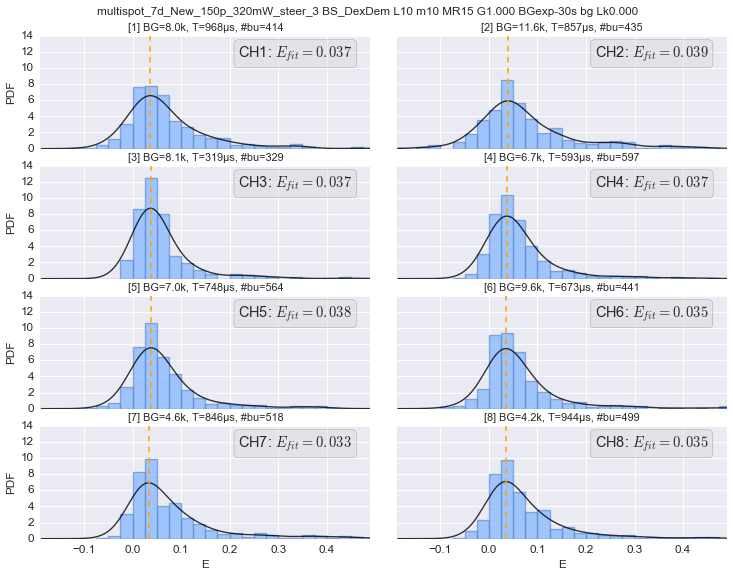

In [18]:
dplot(dx, hist_fret, binwidth=binwidth, weights=weights, show_kde=True, show_kde_peak=True, show_fit_value=True);
plt.xlim(xmax = 0.49)
print_fit_report(E_do.loc[data_id])

<IPython.core.display.Math object>

<IPython.core.display.Math object>

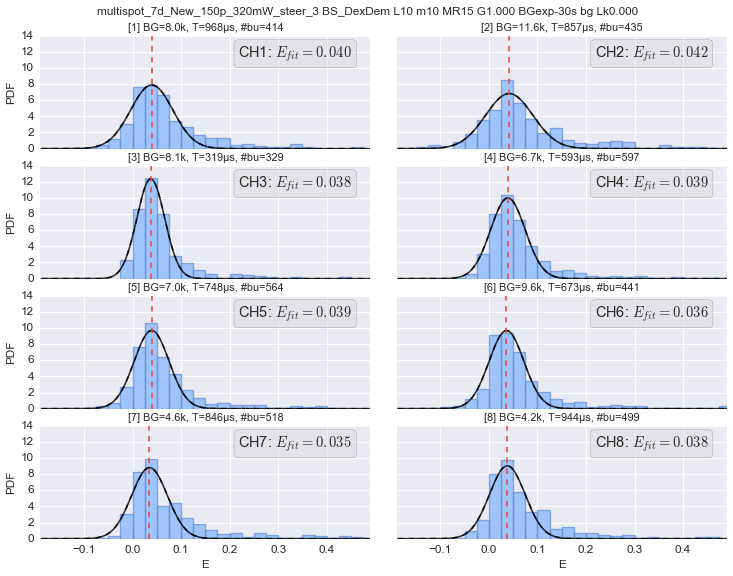

In [19]:
dplot(dx, hist_fret, binwidth=binwidth, weights=weights, show_model=True, show_fit_value=True, fit_from='center');
plt.xlim(xmax = 0.49)
print_fit_report(E_do_g.loc[data_id])

## Alternative plots

<IPython.core.display.Math object>

<IPython.core.display.Math object>

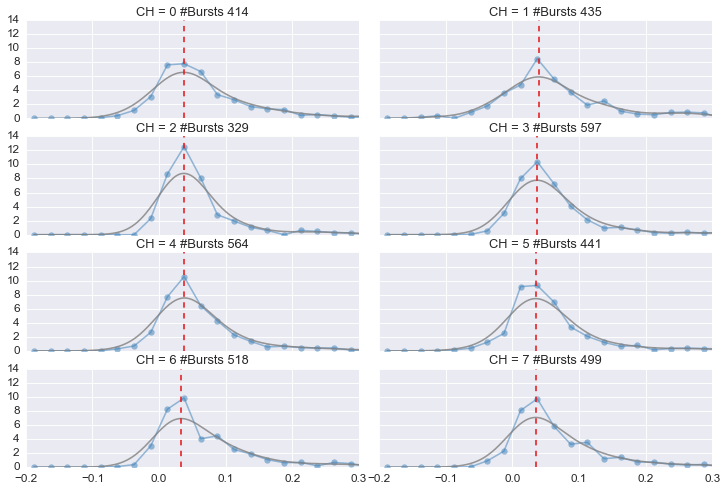

In [20]:
fig, axes = plt.subplots(4, 2, figsize=(12, 8), sharex=True, sharey=True)
fig.subplots_adjust(left=0.08, right=0.96, top=0.93, bottom=0.07,
                    wspace=0.06, hspace=0.18)

for ich, ax in enumerate(axes.ravel()):
    mfit.plot_mfit(dx.E_fitter, ich=ich, ax=ax, plot_model=False, plot_kde=True)
plt.xlim(-0.2, 0.3)
print_fit_report(E_do.loc[data_id])

<IPython.core.display.Math object>

<IPython.core.display.Math object>

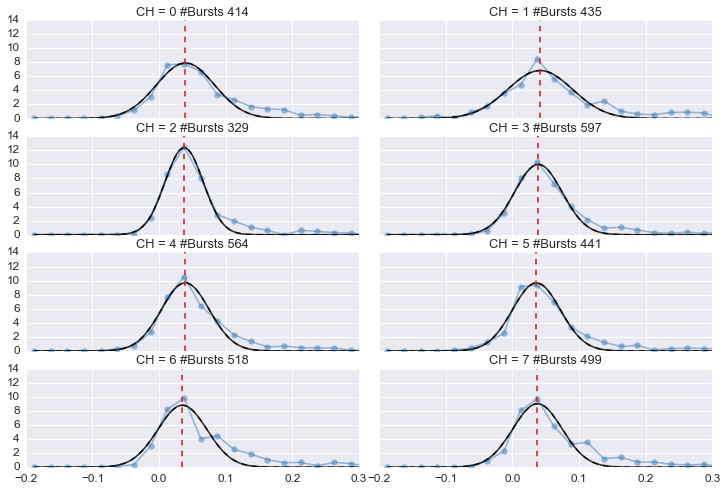

In [21]:
fig, axes = plt.subplots(4, 2, figsize=(12, 8), sharex=True, sharey=True)
fig.subplots_adjust(left=0.08, right=0.96, top=0.93, bottom=0.07,
                    wspace=0.06, hspace=0.18)

for ich, ax in enumerate(axes.ravel()):
    mfit.plot_mfit(dx.E_fitter, ich=ich, ax=ax)
plt.xlim(-0.2, 0.3)
print_fit_report(E_do_g.loc[data_id])

# 12bp sample

In [22]:
data_id = '12d'
d12 = loader.photon_hdf5(files_dict[data_id])
d12.calc_bg(**bg_kwargs_auto)

 - Calculating BG rates ... 

[DONE]


In [23]:
d12.burst_search(m=10, F=F, ph_sel=ph_sel)

 - Performing burst search (verbose=False) ...

 - Recomputing background limits for DexDem ... 

[DONE]


 - Recomputing background limits for all ... 

[DONE]


 - Fixing  burst data to refer to ph_times_m ... 

[DONE]


[DONE]


 - Calculating burst periods ...

[DONE]


 - Counting D and A ph and calculating FRET ... 


   - Applying background correction.


   - Applying leakage correction.


   [DONE Counting D/A]


In [24]:
ds12 = d12.select_bursts(select_bursts.nd, th1=size_min)
dx = ds12

In [25]:
## KDE Fit
E_do.loc[data_id] = bext.fit_bursts_kde_peak(dx, bandwidth=bandwidth, x_range=E_range_do,  
                                             weights=weights)

## Gaussian fit
dx.E_fitter.histogram(binwidth=binwidth, weights=weights)
dx.E_fitter.fit_histogram(mfit.factory_gaussian())
E_do_g.loc[data_id] = dx.E_fitter.params['center']

## D-only selection
do_s = dx.select_bursts(select_bursts.E, E2=0.1)
nbursts.loc[data_id] = do_s.num_bursts

<IPython.core.display.Math object>

<IPython.core.display.Math object>

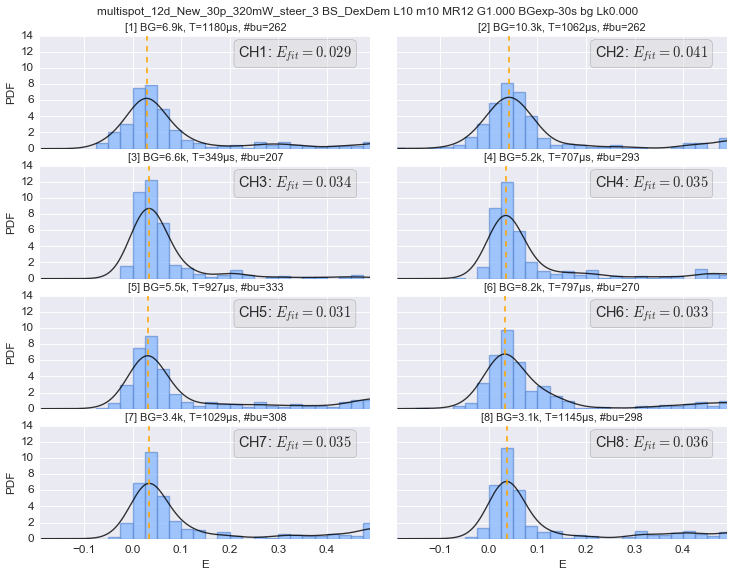

In [26]:
dplot(dx, hist_fret, binwidth=binwidth, weights=weights, show_kde=True, show_kde_peak=True, show_fit_value=True);
plt.xlim(xmax = 0.49)
print_fit_report(E_do.loc[data_id])

<IPython.core.display.Math object>

<IPython.core.display.Math object>

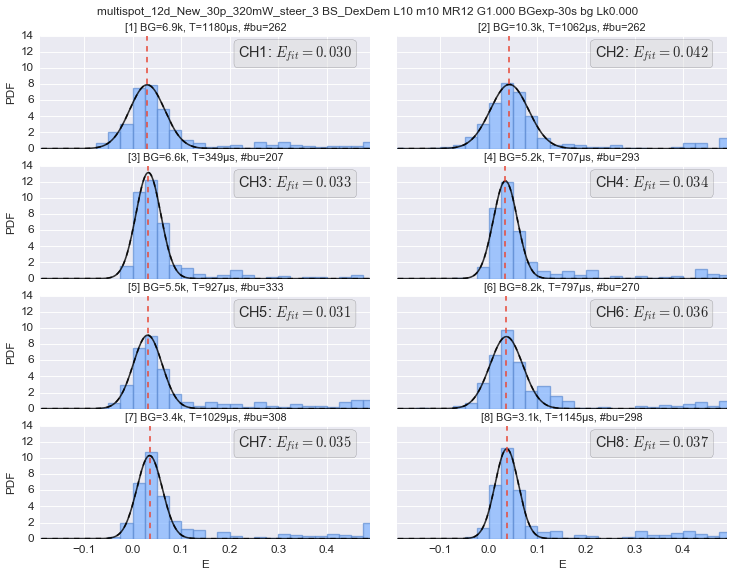

In [27]:
dplot(dx, hist_fret, binwidth=binwidth, weights=weights, show_model=True, show_fit_value=True, fit_from='center');
plt.xlim(xmax = 0.49)
print_fit_report(E_do_g.loc[data_id])

# 17bp sample

In [28]:
data_id = '17d'
d17 = loader.photon_hdf5(files_dict[data_id])
d17.calc_bg(**bg_kwargs_auto)

 - Calculating BG rates ... 

[DONE]


In [29]:
d17.burst_search(m=10, F=F, ph_sel=ph_sel)

 - Performing burst search (verbose=False) ...

 - Recomputing background limits for DexDem ... 

[DONE]


 - Recomputing background limits for all ... 

[DONE]


 - Fixing  burst data to refer to ph_times_m ... 

[DONE]


[DONE]


 - Calculating burst periods ...

[DONE]


 - Counting D and A ph and calculating FRET ... 


   - Applying background correction.


   - Applying leakage correction.


   [DONE Counting D/A]


In [30]:
ds17 = d17.select_bursts(select_bursts.nd, th1=size_min)
dx = ds17

In [31]:
## KDE Fit
E_do.loc[data_id] = bext.fit_bursts_kde_peak(dx, bandwidth=bandwidth, x_range=E_range_do,  
                                             weights=weights)

## Gaussian fit
dx.E_fitter.histogram(binwidth=binwidth, weights=weights)
dx.E_fitter.fit_histogram(mfit.factory_two_gaussians(p1_center=0.03, p2_center=0.25))
E_do_g.loc[data_id] = dx.E_fitter.params['p1_center']

## D-only selection
do_s = Sel(dx, select_bursts.E, E2=0.1)
nbursts.loc[data_id] = do_s.num_bursts

<IPython.core.display.Math object>

<IPython.core.display.Math object>

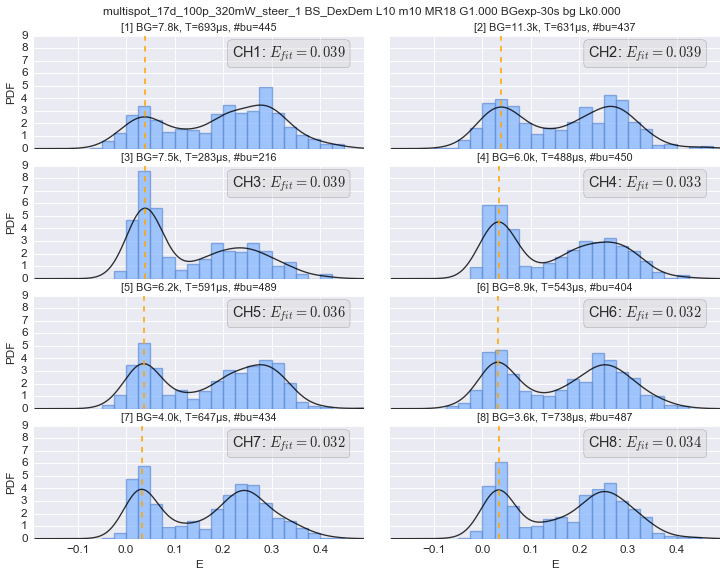

In [32]:
dplot(dx, hist_fret, binwidth=binwidth, weights=weights, show_kde=True, show_kde_peak=True, show_fit_value=True);
plt.xlim(xmax = 0.49)
print_fit_report(E_do.loc[data_id])

<IPython.core.display.Math object>

<IPython.core.display.Math object>

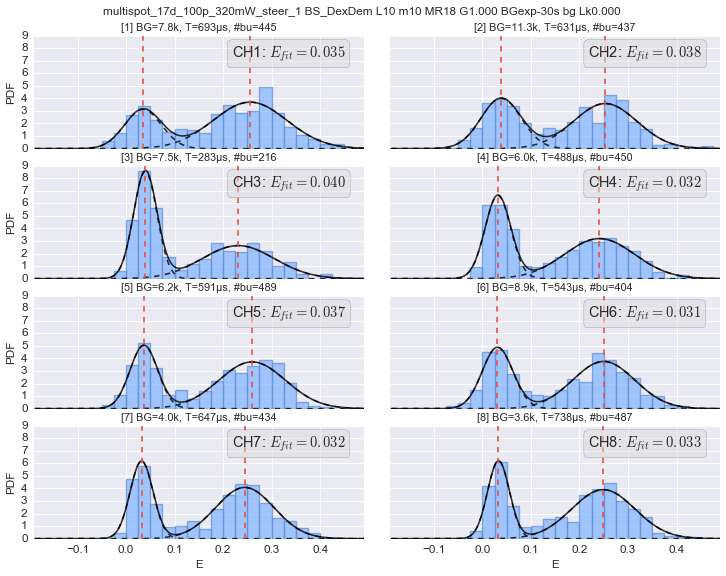

In [33]:
dplot(dx, hist_fret, binwidth=binwidth, weights=weights, show_model=True, show_fit_value=True, fit_from='p1_center');
plt.xlim(xmax = 0.49)
print_fit_report(E_do_g.loc[data_id])

# DO sample

In [34]:
data_id = 'DO'
do = loader.photon_hdf5(files_dict[data_id])
do.calc_bg(**bg_kwargs_auto)

 - Calculating BG rates ... 

[DONE]


In [35]:
do.burst_search(L=10, m=10, F=F, ph_sel=ph_sel)

 - Performing burst search (verbose=False) ...

 - Recomputing background limits for DexDem ... 

[DONE]


 - Recomputing background limits for all ... 

[DONE]


 - Fixing  burst data to refer to ph_times_m ... 

[DONE]


[DONE]


 - Calculating burst periods ...

[DONE]


 - Counting D and A ph and calculating FRET ... 


   - Applying background correction.


   - Applying leakage correction.


   [DONE Counting D/A]


In [36]:
dos = do.select_bursts(select_bursts.nd, th1=size_min)
dx = dos

In [37]:
## KDE Fit
E_do.loc[data_id] = bext.fit_bursts_kde_peak(dx, bandwidth=bandwidth, x_range=E_range_do,  
                                             weights=weights)

## Gaussian fit
dx.E_fitter.histogram(binwidth=binwidth, weights=weights)
dx.E_fitter.fit_histogram(mfit.factory_gaussian())
E_do_g.loc[data_id] = dx.E_fitter.params['center']

## D-only selection
nbursts.loc[data_id] = dx.num_bursts

<IPython.core.display.Math object>

<IPython.core.display.Math object>

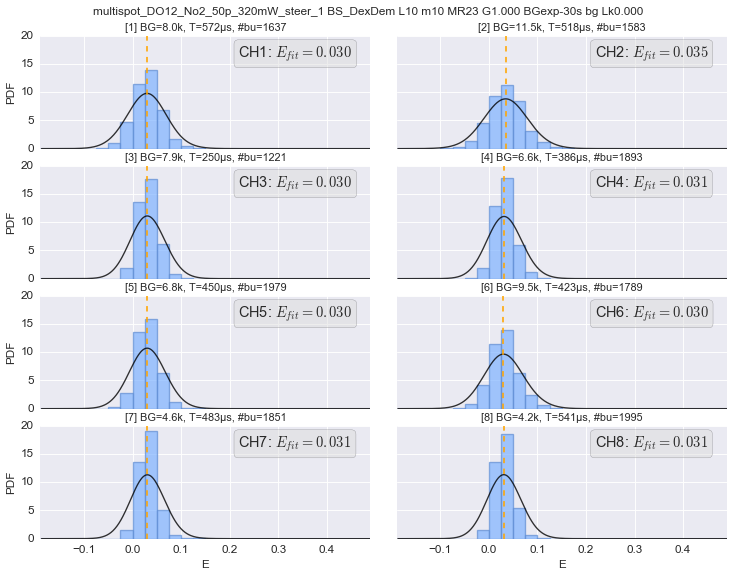

In [38]:
dplot(dx, hist_fret, binwidth=binwidth, weights=weights, show_kde=True, show_kde_peak=True, show_fit_value=True);
plt.xlim(xmax = 0.49)
print_fit_report(E_do.loc[data_id])

<IPython.core.display.Math object>

<IPython.core.display.Math object>

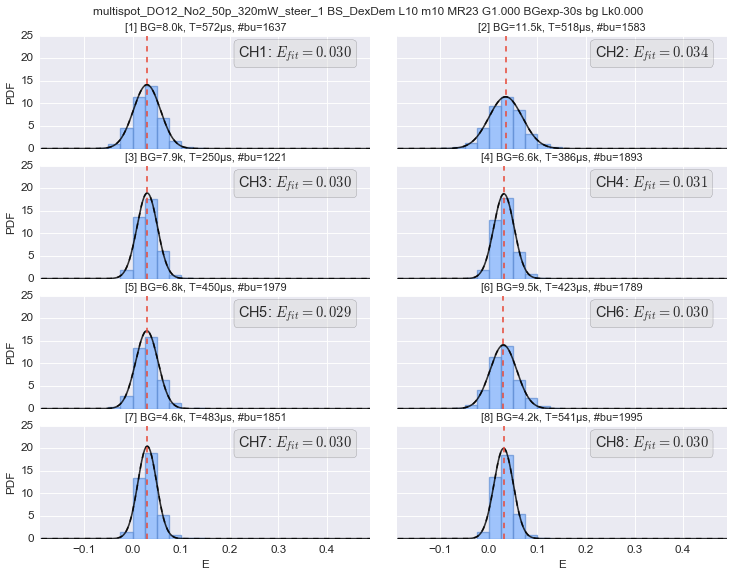

In [39]:
dplot(dx, hist_fret, binwidth=binwidth, weights=weights, show_model=True, show_fit_value=True, fit_from='center');
plt.xlim(xmax = 0.49)
print_fit_report(E_do_g.loc[data_id])

# Results

In [40]:
ph_sel

Ph_sel(Dex='Dem', Aex=None)

In [41]:
nbursts = nbursts.astype(int)
nbursts

Channel,0,1,2,3,4,5,6,7
Sample,,,,,,,,
7d,318,329,288,504,465,365,397,393
12d,197,199,177,235,237,203,223,217
17d,144,178,119,205,190,165,171,189
DO,1637,1583,1221,1893,1979,1789,1851,1995


In [42]:
E_do_kde = E_do.copy()

In [43]:
leakage_kde = (E_do_kde / (1 - E_do_kde)).round(6)
leakage_kde

Channel,0,1,2,3,4,5,6,7
Sample,,,,,,,,
7d,0.038206,0.041016,0.038637,0.038637,0.039501,0.036484,0.034340,0.036269
12d,0.029654,0.043188,0.034982,0.035840,0.032205,0.033699,0.035840,0.037775
17d,0.040150,0.040366,0.041016,0.034340,0.037560,0.032631,0.033485,0.034768
DO,0.030715,0.035840,0.031353,0.032205,0.031140,0.030928,0.031566,0.031566


In [44]:
leakage_gauss = (E_do_g / (1 - E_do_g)).round(6)
leakage_gauss

Channel,0,1,2,3,4,5,6,7
Sample,,,,,,,,
7d,0.041173,0.043589,0.039049,0.040638,0.040913,0.037526,0.036188,0.039272
12d,0.031078,0.044064,0.033672,0.035055,0.032208,0.037212,0.036395,0.038132
17d,0.036252,0.039984,0.041322,0.032848,0.038075,0.031988,0.033045,0.034200
DO,0.030591,0.035656,0.031211,0.031850,0.030329,0.030641,0.031228,0.031193


In [45]:
sns.set(style='ticks', font_scale=1.4)

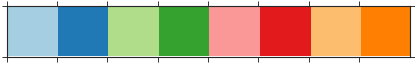

In [46]:
colors = sns.color_palette('Paired', 8)
mpl.rcParams['axes.prop_cycle'] = cycler('color', colors)
sns.palplot(colors)

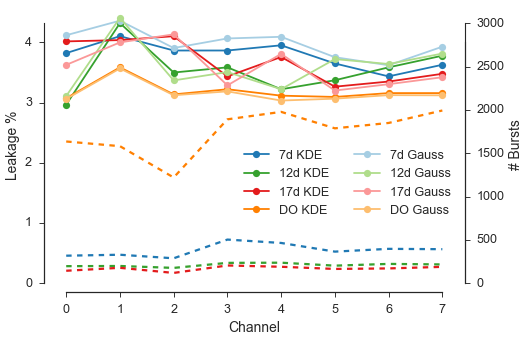

In [47]:
fig, ax = plt.subplots()
ax2 = ax.twinx()

kws = dict(lw=2, marker='o', ms=8)
for i, did in enumerate(('7d', '12d', '17d', 'DO')):
    (100*leakage_kde).loc[did].plot(label='%s KDE' % did, ax=ax, color=colors[1+i*2], **kws)
    nbursts.loc[did].plot(ax=ax2, ls='--', lw=2.5, color=colors[1+i*2])

for i, did in enumerate(('7d', '12d', '17d', 'DO')):    
    (100*leakage_gauss).loc[did].plot(label='%s Gauss' % did, ax=ax, color=colors[i*2], **kws)
    
handles, lab = ax.get_legend_handles_labels()
h = handles#[1::2] + handles[::2]
l = lab[1::2] + lab[::2]
ax.legend(ncol=2, loc=1, bbox_to_anchor=(1, 0.5), borderaxespad=0.)
ax.set_ylim(0)

ax2.set_ylim(0, 3200)
plt.xlim(-0.25, 7.25)
plt.xlabel('Channel')
ax.set_ylabel('Leakage %')
ax2.set_ylabel('# Bursts')
sns.despine(offset=10, trim=True, right=False)

# Save results

In [48]:
leakage_kde.to_csv('results/Multi-spot - leakage coefficient all values KDE %s.csv' % str(ph_sel))
leakage_gauss.to_csv('results/Multi-spot - leakage coefficient all values gauss %s.csv' % str(ph_sel))
nbursts.to_csv('results/Multi-spot - leakage coefficient all values nbursts %s.csv' % str(ph_sel))

# Average leakage

### Mean per sample:

In [49]:
lk_s = pd.DataFrame(index=['mean', 'std'], columns=E_do.index)

lk_s.loc['mean'] = leakage_kde.mean(1)*100
lk_s.loc['std'] = leakage_kde.std(1)*100

lk_s['mean'] = lk_s.mean(1)
lk_s

Sample,7d,12d,17d,DO,mean
mean,3.78862,3.53979,3.67895,3.19141,3.549694
std,0.209727,0.401734,0.339833,0.165028,0.279081


In [50]:
lk_s.T[['std']]

,std
Sample,
7d,0.209727
12d,0.401734
17d,0.339833
DO,0.165028
mean,0.279081


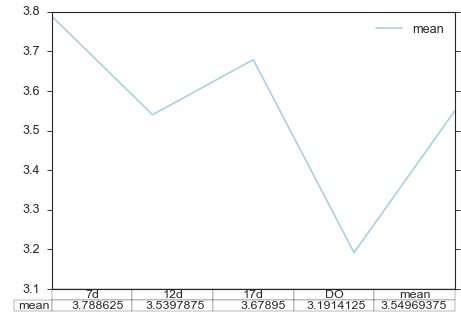

In [51]:
lk_s.T[['mean']].plot(table=True)
plt.gca().xaxis.set_visible(False)   # Hide Ticks

### Mean per sample (weighted on the number of bursts):

Number of bursts in D-only population:

In [52]:
nbursts

Channel,0,1,2,3,4,5,6,7
Sample,,,,,,,,
7d,318,329,288,504,465,365,397,393
12d,197,199,177,235,237,203,223,217
17d,144,178,119,205,190,165,171,189
DO,1637,1583,1221,1893,1979,1789,1851,1995


In [53]:
lk_sw = pd.DataFrame(index=['mean', 'std'], columns=E_do.index)

lk_sw.loc['mean'] = (nbursts*leakage_kde).sum(1)/nbursts.sum(1)*100
lk_sw.loc['std'] = (nbursts*leakage_kde).std(1)/nbursts.sum(1)*100

lk_sw['mean'] = (nbursts.sum(1)*lk_sw).sum(1)/nbursts.sum(1).sum()
lk_sw

Sample,7d,12d,17d,DO,mean
mean,3.78606,3.53753,3.65209,3.1877,3.339920
std,0.095557,0.0620508,0.0650953,0.0579312,0.064503


(2, 4)

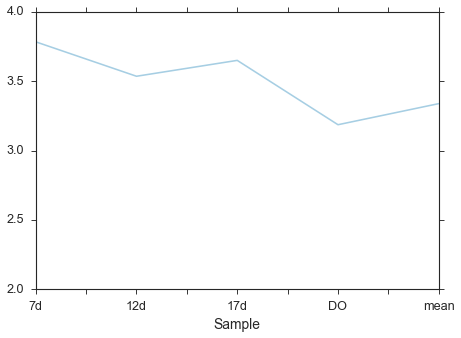

In [54]:
lk_sw.loc['mean'].plot()
ylim(2, 4)

### Mean per channel:

In [55]:
lk_c = pd.DataFrame(index=['mean', 'std'], columns=E_do.columns)

lk_c.loc['mean'] = leakage_kde.mean()*100
lk_c.loc['std'] = leakage_kde.std()*100

lk_c['mean'] = lk_c.mean(1)
lk_c

Channel,0,1,2,3,4,5,6,7,mean
mean,3.46812,4.01025,3.6497,3.52555,3.51015,3.34355,3.38077,3.50945,3.549694
std,0.527053,0.308724,0.423308,0.270308,0.406132,0.233078,0.178353,0.265339,0.326537


(2, 4)

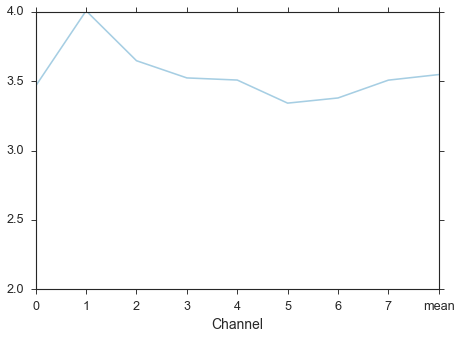

In [56]:
lk_c.loc['mean'].plot()
ylim(2, 4)

### Mean per channel (weighted on the number of bursts):

In [57]:
lk_cw = pd.DataFrame(index=['mean', 'std'], columns=E_do.columns)

lk_cw.loc['mean'] = (nbursts*leakage_kde).sum()/nbursts.sum()*100
lk_cw.loc['std'] = (nbursts*leakage_kde).std()/nbursts.sum()*100

lk_cw['mean'] = lk_cw.mean(1)
lk_cw

Channel,0,1,2,3,4,5,6,7,mean
mean,3.22532,3.75747,3.35081,3.3803,3.3007,3.20666,3.24678,3.29263,3.345085
std,0.931524,1.03292,0.868335,0.891061,0.899184,0.938172,0.94167,0.961142,0.933001


(2, 4)

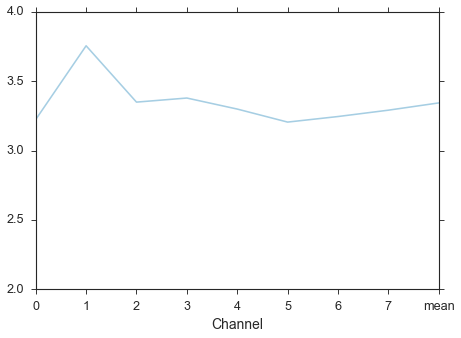

In [58]:
lk_cw.loc['mean'].plot()
ylim(2, 4)

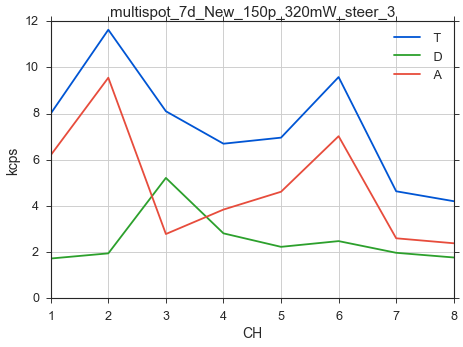

In [59]:
mch_plot_bg(d7)

> **NOTE:** There is a per-channel trend that cannot be ascribed to the background 
> because we performend a D-emission burst search and selection and the leakage vs ch
> does not resemble the D-background vs channel curve.
>
> The effect is probably due to slight PDE variations (detectors + optics) that 
> slightly change $\gamma$ on a per-spot basis.

### Weighted mean of the weighted mean

In [60]:
lk = (lk_cw.ix['mean', :-1]*nbursts.mean()).sum()/(nbursts.mean().sum())/100
lk_2 = (lk_sw.ix['mean', :-1]*nbursts.mean(1)).sum()/(nbursts.mean(1).sum())/100

assert np.allclose(lk, lk_2)

print('Mean leakage: %.6f' % lk)

Mean leakage: 0.033399
